## Playing with FERC 1 Fuel data
This notebook is meant to help get you understand the data cleaning process for FERC Form 1 fuel data for heat content and price per MMBTU data.

### Importing external code.
We need to import a bunch of outside code to do our work here.  Sometimes we import entire packages (like `numpy` and `pandas`) and sometimes we just pull in a couple of pieces we need from a particular part of a large package (like `declarative_base`)

In [1]:
import sys
import os.path
import numpy as np
import pandas as pd
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.engine.url import URL
import matplotlib.pyplot as plt

### Importing our own code
We also need to tell Python where to look to find our own code.  It has a list of directories that it looks in, but our little project isn't in that list, unless we add it -- which is what `sys.path.append()` does.  You'll need to change this path to reflect where on your computer the PUDL project folder (which you pull down with `git`) lives.

Once Python knows to look in the `pudl` project folder, it will let you import `pudl` modules just like any other Python module.  Here we're pulling in the `ferc1` and `pudl` modules from the `pudl` package (which is a directory inside the `pudl` project directory).

In [2]:
sys.path.append('/Users/christinagosnell/code/pudl')
sys.path.append('/Users/zaneselvans/code/catalyst/pudl')
sys.path.append('/Users/Nannerz/Desktop/working/pudl/')
sys.path.append('/home/alana/Dropbox/catalyst/pudl')
from pudl import ferc1, pudl, models, models_ferc1, settings, constants

### Automatically reloading a work in progress
Because you're probably going to be editing the Python modules related to PUDL while you're working with this notebook, it's useful to have them get automatically reloaded before every cell is executed -- this means you're always using the freshest version of the module, with all your recent edits.

In [3]:
%load_ext autoreload
%autoreload 1
%aimport pudl.pudl
%aimport pudl.ferc1
%aimport pudl.constants
%aimport pudl.settings
%aimport pudl.models

### Connecting to our databases.
We have two different databases that we're working with right now.  The FERC Form 1 (`ferc1`) and our own PUDL database (`pudl`). For this software to work, you'll need to have the Postgresql database server running on your computer, and you'll need to have created empty databases to receive the tables and data we're going to create.  On a mac, the easiest Postgres install to get running is probably Postgress.app.  You'll need to fire it up at the command line at least once to create the databases (one called `ferc1` and another called `pudl_sandbox`) and a user named `catalyst` with no password.  This information is stored in the `settings` module if you need to look it up.

Here are two shortcuts for connecting to the two databases once they're created:

In [4]:
pudl_engine  = pudl.pudl.db_connect_pudl()
ferc1_engine = pudl.ferc1.db_connect_ferc1()

### Initializing the FERC Form 1 database
Now that you've got an empty database, let's put some data in it!  This function initializes the database by reading in the FERC Form 1 database structure from `refyear` and data from `years` (which can eventually be a list of years, but that's not working yet...). In order for this to work, you need to have the FERC Form 1 data downloaded into the data directory. There's a script called `get_ferc1.sh` down in `data/ferc/form1/` that will get it for you if you don't have it.

In [5]:
pudl.ferc1.init_db(refyear=2015, years=[2007,2008,2009,2010,2011,2012,2013,2014,2015], ferc1_tables=pudl.constants.ferc1_default_tables)

Defining new FERC Form 1 DB based on 2015...
Clearing any existing FERC Form 1 database MetaData...
Ingesting FERC Form 1 Data from 2007...
Ingesting FERC Form 1 Data from 2008...
Ingesting FERC Form 1 Data from 2009...
Ingesting FERC Form 1 Data from 2010...
Ingesting FERC Form 1 Data from 2011...
Ingesting FERC Form 1 Data from 2012...
Ingesting FERC Form 1 Data from 2013...
Ingesting FERC Form 1 Data from 2014...
Ingesting FERC Form 1 Data from 2015...


### Initializing the PUDL database
We'll pull in FERC 1 fuel, FERC 1 steam, and EIA 923's Fuel Receipts and Costs

In [6]:
pudl.pudl.init_db(ferc1_tables=['f1_fuel','f1_steam'], ferc1_years=[2007,2008,2009,2010,2011,2012,2013,2014,2015],\
                                  eia923_tables=['fuel_receipts_costs_eia923','generation_fuel_eia923'], eia923_years=[2011,2012,2013,2014,2015], debug=True)

Ingesting static PUDL tables...
Sniffing EIA923/FERC1 glue tables...
Ingesting f1_fuel from FERC Form 1 into PUDL.
Ingesting f1_steam from FERC Form 1 into PUDL.
Reading EIA 923 spreadsheet data for 2011.
Reading EIA 923 spreadsheet data for 2012.
Reading EIA 923 spreadsheet data for 2013.
Reading EIA 923 spreadsheet data for 2014.
Reading EIA 923 spreadsheet data for 2015.
Converting EIA 923 generation_fuel to DataFrame...
Converting EIA 923 stocks to DataFrame...
Converting EIA 923 boiler_fuel to DataFrame...
Converting EIA 923 generator to DataFrame...
Converting EIA 923 fuel_receipts_costs to DataFrame...
Converting EIA 923 plant_frame to DataFrame...
Converting EIA 923 generation_fuel to DataFrame...
Converting EIA 923 boiler_fuel to DataFrame...
Converting EIA 923 generator to DataFrame...
Converting EIA 923 fuel_receipts_costs to DataFrame...
Ingesting generation_fuel_eia923 from EIA 923 into PUDL.
Ingesting fuel_receipts_costs_eia923 from EIA 923 into PUDL.


## Average heat content per unit, coal and gas

### Pull applicable data from PUDL FERC tables

In [51]:
fuel_df = pd.read_sql('''SELECT * from fuel_ferc1''',pudl_engine)
coal = fuel_df[fuel_df.fuel=='coal']
gas = fuel_df[fuel_df.fuel=='gas']

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


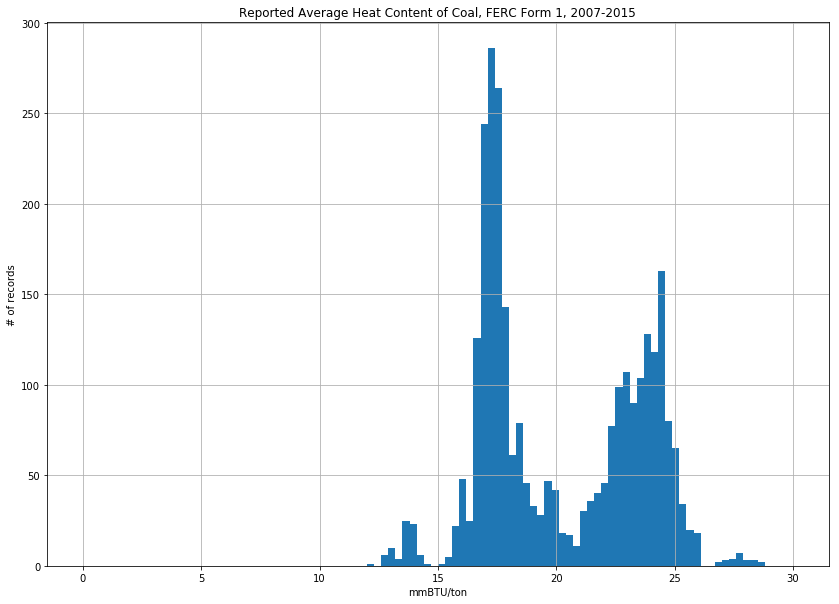

In [8]:
def fixit(tofix, min, max, mults):
    fixed = tofix.copy()
    for mult in mults:
        fixed = fixed.apply(lambda x: x*mult if x > min/mult and x < max/mult else x)
    fixed = fixed.apply(lambda x: np.nan if x < min or x > max else x)
    return(fixed)

fixed_coal_avg_heat_content = fixit(coal.fuel_avg_mmbtu_per_unit,10,30,[2000,1e6,2000e6])

fig = plt.figure(figsize=(14,10))
plt.grid()
plt.title("Reported Average Heat Content of Coal, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("mmBTU/ton")

plt.hist(fixed_coal_avg_heat_content, bins=100, range=(0,30))
plt.show()

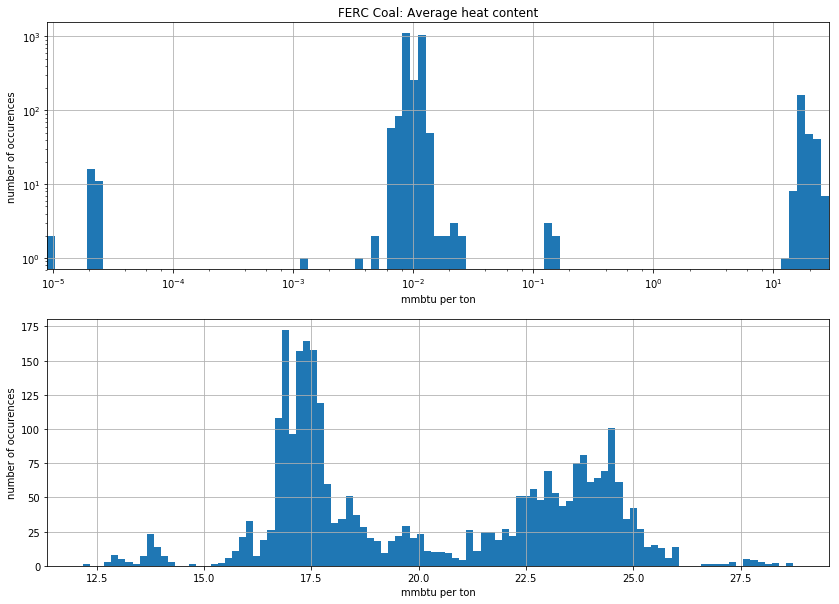

(<matplotlib.figure.Figure at 0x1419b4c88>, 2.2574123989218329)

In [94]:
def fixit(tofix, min, max, mults):
    
    fixed = tofix.copy()
    for mult in mults:
        fixed = fixed.apply(lambda x: x*mult if x > min/mult and x < max/mult else x)
    fixed = fixed.apply(lambda x: np.nan if x < min or x > max else x)
    return(fixed)

def showfix(tofix,fixed,title,xlabel,ylabel):
    
    min_1 = tofix[tofix > 0].min()
    max_1 = tofix.max()
    
    fig_1 = plt.figure(figsize=(14,10))
    plt.subplot(2,1,1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    ax = fig_1.axes[0]
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.xlim(min_1,max_1)
    plt.hist(tofix, bins=np.logspace(np.log10(min_1), np.log10(max_1), 100))
    
    plt.subplot(2,1,2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.hist(fixed.dropna(),bins=100)
    plt.show()
    
    na_percentage =  ( fixed.isnull().sum() / len(fixed) ) * 100
    
    return(fig_1, na_percentage)

to_fix_avg_heat_content_coal = coal.fuel_avg_mmbtu_per_unit
fixed_avg_heat_content_coal = fixit(coal.fuel_avg_mmbtu_per_unit,10,30,[2000,1e6,2000e6])

showfix(to_fix_avg_heat_content_coal,fixed_avg_heat_content_coal,'FERC Coal: Average heat content',\
        'mmbtu per ton','number of occurences')

In [ ]:
to_fix_avg_heat_content_gas = gas.fuel_avg_mmbtu_per_unit
fixed_avg_heat_content_gas = fixit(gas.fuel_avg_mmbtu_per_unit,.75,1.25,[1000,1e6])

showfix(to_fix_avg_heat_content_gas,fixed_avg_heat_content_gas,'FERC Gas: Average heat content',\
        'mmbtu per mcf','number of occurences')

In [ ]:
to_fix_cost_per_mmbtu_gas = gas.fuel_cost_per_mmbtu
fixed_cost_per_mmbtu_gas = fixit(gas.fuel_cost_per_mmbtu,2.5,17.5,[.01,1000,10])

showfix(to_fix_avg_heat_content_gas,fixed_cost_per_mmbtu_gas,'FERC Gas: Cost per mmbtu',\
        'dollars per mmbtu','number of occurences')

In [ ]:
to_fix_cost_per_mmbtu_coal = coal.fuel_cost_per_mmbtu
fixed_cost_per_mmbtu_coal = fixit(coal.fuel_cost_per_mmbtu,.5,7.5,[.01,2000])

showfix(to_fix_avg_heat_content_coal,fixed_cost_per_mmbtu_coal,'FERC Coal: Cost per mmbtu',\
        'dollars per mmbtu','number of occurences')

## EIA 923 Heat rate

In [38]:
mwh_eia923 = pd.read_sql('''SELECT * FROM generation_fuel_eia923''', pudl_engine)

In [41]:
# Summarize data by year for each plant; this creates a new column that reports the annual sum in each row
mwh_eia923["fuel_consumed_total_mmbtu_sum"] = mwh_eia923.groupby(["plant_id", "year"])["fuel_consumed_total_mmbtu"].transform(sum)
mwh_eia923["net_generation_mwh_sum"] = mwh_eia923.groupby(["plant_id", "year"])["net_generation_mwh"].transform(sum)

In [42]:
# Use sum of fuel_consumed_total_mmbtu_sum and net_generation_mwh_sum to calculate annual heat rate 
# for each plant id
mwh_eia923['calculated_heat_rate_btu_per_kwh'] = \
((mwh_eia923['fuel_consumed_total_mmbtu_sum']*1000000)/(mwh_eia923['net_generation_mwh_sum']*1000))

### Looking at coal first

In [44]:
mwh_eia923_coal = mwh_eia923[(mwh_eia923.aer_fuel_category == 'coal')]

In [55]:
mwh_eia923_coal.calculated_heat_rate_btu_per_kwh.quantile(q=[.05,.95])

0.05     9219.826363
0.95    30637.180956
Name: calculated_heat_rate_btu_per_kwh, dtype: float64

In [71]:
mwh_eia923_coal.calculated_heat_rate_btu_per_kwh.quantile(q=[.01,.99])

0.01     7195.617373
0.99    46922.623440
Name: calculated_heat_rate_btu_per_kwh, dtype: float64

### Looking at gas

In [45]:
mwh_eia923_gas = mwh_eia923[(mwh_eia923.aer_fuel_category == 'gas')]

In [97]:
mwh_eia923_gas.calculated_heat_rate_btu_per_kwh.quantile(q=[.01,.05,.95,.99])

0.01     1173.108028
0.05     6178.320997
0.95    28887.914285
0.99    52207.568300
Name: calculated_heat_rate_btu_per_kwh, dtype: float64

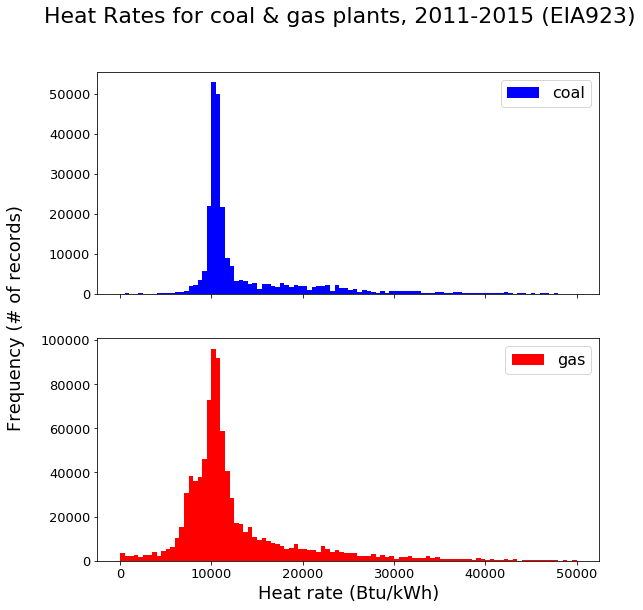

In [52]:
# Plot heat rate histogram for full data set by fuel type
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(mwh_eia923_coal.calculated_heat_rate_btu_per_kwh, color= 'b', label='coal', range=(0,50000), bins=100)
ax1.legend(loc="upper right", fontsize=16)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.hist(mwh_eia923_gas.calculated_heat_rate_btu_per_kwh, color= 'r', label='gas', range=(0,50000), bins=100)
ax2.legend(loc="upper right", fontsize=16)
plt.suptitle('Heat Rates for coal & gas plants, 2011-2015 (EIA923)', size=22)
ax2.set_xlabel('Heat rate (Btu/kWh)', size=18)
f.text(0.0, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', size=18)
f.set_size_inches(9,9)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

## FERC Heat rates

In [60]:
coal.head(1)

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
0,1,186,Altavista,2007,coal,ton,152665.0,0.01283,80.46,79.83,3.14,34.0,11.895


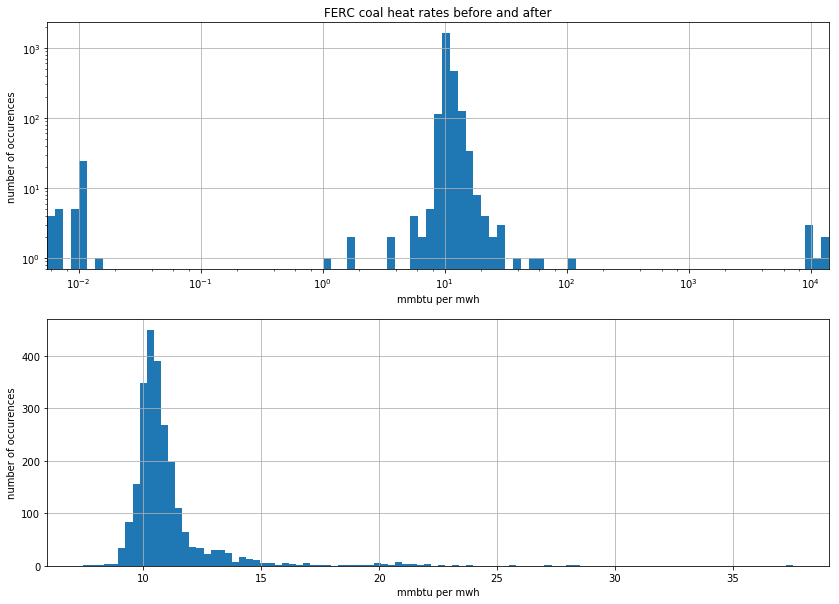

(<matplotlib.figure.Figure at 0x19baaada0>, 0.61830173124484744)

In [101]:
coal_above_zero = coal[coal.fuel_mmbtu_per_mwh > 0]
coal_fix = fixit(coal_above_zero.fuel_mmbtu_per_mwh,7.195,46.922,[2000,.001])
showfix(coal.fuel_mmbtu_per_mwh,coal_fix,'FERC coal heat rates before and after','mmbtu per mwh','number of occurences')

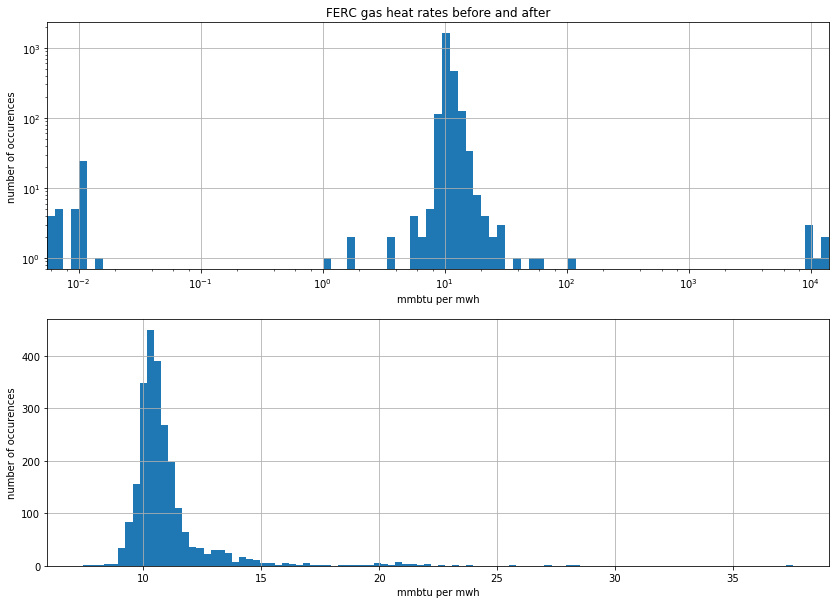

(<matplotlib.figure.Figure at 0x17e0e3f28>, 0.61830173124484744)

In [103]:
gas_above_zero = gas[gas.fuel_mmbtu_per_mwh > 0]
gas_fix = fixit(gas_above_zero.fuel_mmbtu_per_mwh,1.173,52.207,[2000,.001])
showfix(coal.fuel_mmbtu_per_mwh,coal_fix,'FERC gas heat rates before and after','mmbtu per mwh','number of occurences')

## EIA: Fuel Cost per mWh

In [442]:
# get fuel receipts and costs key columns
fuel_rc = pd.read_sql('''SELECT fuel_quantity,fuel_group, average_heat_content, fuel_cost, plant_id, month, year FROM fuel_receipts_costs_eia923''', con = pudl_engine)

In [443]:
# convert cost from cents to dollars
fuel_rc['fuel_cost'] = fuel_rc['fuel_cost'] * .01

In [444]:
# compute monthly cost by plant
fuel_rc['monthly_cost'] = fuel_rc['fuel_quantity'] * fuel_rc['fuel_cost'] * fuel_rc['average_heat_content']

In [449]:
# sum monthly costs for each plant in each year to get the annual cost for the plant
fuel_rc['annual_fuel_cost'] = fuel_rc.groupby(['plant_id','year'])['monthly_cost'].transform(sum)

### Since many plants have more than one fuel, we need to determine the dominant type of fuel for the plant. We can find out which type of fuel the plant spends the most on, and use this to split plants into coal and gas.

In [453]:
# split the annual cost by the type of fuel consumed
fuel_rc['annual_fuel_cost_by_type'] = fuel_rc.groupby(['plant_id','year','fuel_group'])['monthly_cost'].transform(sum)

In [460]:
# sort by the annual cost for each type of fuel
fuel_rc.sort_values(['annual_fuel_cost_by_type'],inplace=True)

In [ ]:
# look at an example of a plant that consumes both coal and gas
fuel_rc[(fuel_rc.plant_id == 3) & (fuel_rc.year == 2014)]

In [462]:
# drop duplicates of the plant record but keep the record that has the highest amount spent on fuel
fuel_rc_one_record_per_plant = fuel_rc.drop_duplicates(subset=['plant_id','annual_fuel_cost','year'],keep='last')

In [463]:
# look at our example again
fuel_rc_one_record_per_plant[(fuel_rc_one_record_per_plant.plant_id == 3) & (fuel_rc_one_record_per_plant.year == 2014)]

,fuel_quantity,fuel_group,average_heat_content,fuel_cost,plant_id,month,year,monthly_cost,annual_fuel_cost,annual_fuel_cost_by_type
134800,236222.0,Natural Gas,1.021,4.624,3,1,2014,1.115229e+06,4.473211e+08,2.542320e+08


In [ ]:
# pull in columns for net generation
eia_mwh = mwh_eia923[['net_generation_mwh_sum','plant_id','year']]

In [472]:
eia_mwh_one_record_per_plant = eia_mwh.drop_duplicates(subset=['net_generation_mwh_sum','plant_id','year'])

In [474]:
# merge our fuel cost and net generation dataframes
eia_merged = pd.merge(fuel_rc_one_record_per_plant,eia_mwh_one_record_per_plant,\
                     on=['plant_id','year'], how='left')

In [476]:
#  compute cost per megawatt hour
eia_merged['cost_mwh'] = eia_merged['annual_fuel_cost'] / eia_merged['net_generation_mwh_sum']

### Cost per mwh quantiles and graphs

In [479]:
coal_eia = eia_merged[eia_merged['fuel_group'] == 'Coal']
coal_eia_no_zero = coal_eia[coal_eia['cost_mwh'] > 0]
coal_eia.cost_mwh.quantile(q=[.05,.1,.2,.5,.95])

0.05     0.680742
0.10     1.428817
0.20     2.941268
0.50     8.871881
0.95    29.755172
Name: cost_mwh, dtype: float64

In [ ]:
coal_eia_no_zero.nlargest(columns=['cost_mwh'],n=50)

In [480]:
gas_eia = eia_merged[eia_merged['fuel_group'] == 'Natural Gas']
gas_eia_no_zero = gas_eia[gas_eia['cost_mwh'] > 0]
gas_eia_no_zero.cost_mwh.quantile(q=[.05,.1,.2,.5,.95])

0.05     0.095680
0.10     0.304668
0.20     0.923750
0.50     6.275905
0.95    37.834536
Name: cost_mwh, dtype: float64

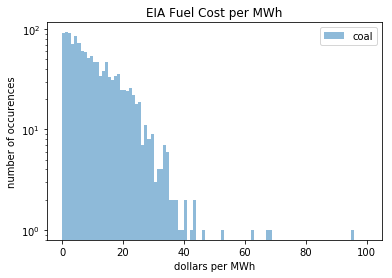

In [496]:
plt.hist(coal_eia_no_zero.cost_mwh,bins=100,range=(0,100),log=True,alpha=.5,label='coal')
plt.xlabel('dollars per MWh')
plt.ylabel('number of occurences')
plt.legend()
plt.title('EIA Fuel Cost per MWh')
plt.show()

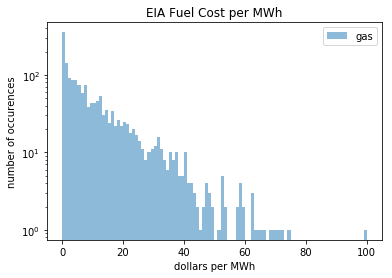

In [498]:
plt.hist(gas_eia_no_zero.cost_mwh,bins=100,range=(0,100),log=True,alpha=.5,label='gas')
plt.xlabel('dollars per MWh')
plt.ylabel('number of occurences')
plt.legend()
plt.title('EIA Fuel Cost per MWh')
plt.show()

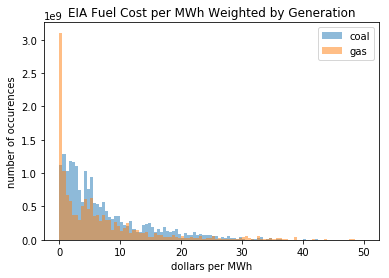

In [484]:
plt.hist(coal_eia_no_zero.cost_mwh,bins=100,range=(0,50), weights=coal_eia_no_zero.net_generation_mwh_sum,alpha=.5,label='coal')
plt.hist(gas_eia_no_zero.cost_mwh,weights=gas_eia_no_zero.net_generation_mwh_sum,bins=100,range=(0,50),alpha=.5,label='gas')
plt.xlabel('dollars per MWh')
plt.ylabel('MWh')
plt.legend()
plt.title('EIA Fuel Cost per MWh Weighted by Generation')
plt.show()

## FERC Fuel cost per MWh

In [196]:
coal.head(1)

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
0,1,186,Altavista,2007,coal,ton,152665.0,0.01283,80.46,79.83,3.14,34.0,11.895


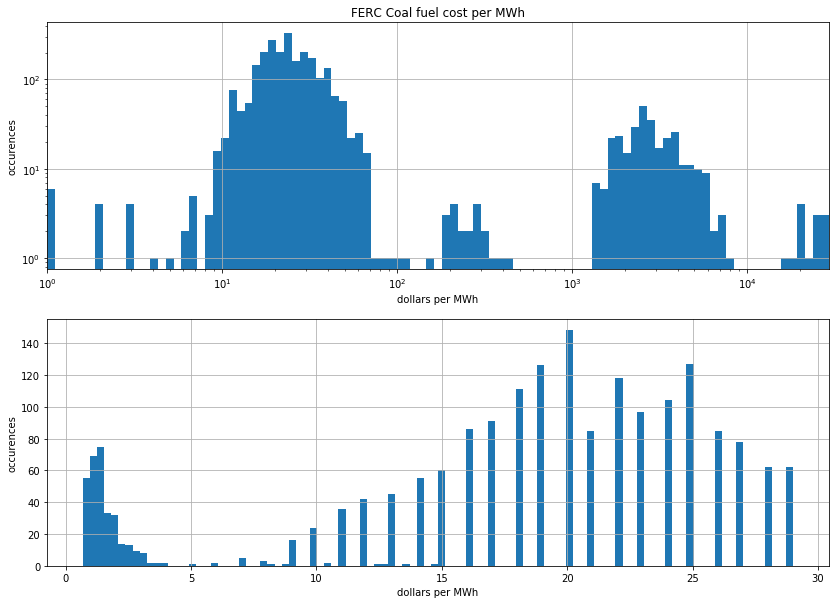

(<matplotlib.figure.Figure at 0x1422feda0>, 32.917789757412393)

In [516]:
to_fix_coal_cost_per_mwh = coal.fuel_cost_per_mwh
fixed_coal_per_mwh = fixit(coal.fuel_cost_per_mwh,.68,29.75,[1,.0005])

showfix(to_fix_coal_cost_per_mwh,fixed_coal_per_mwh,'FERC Coal fuel cost per MWh','dollars per MWh','occurences')

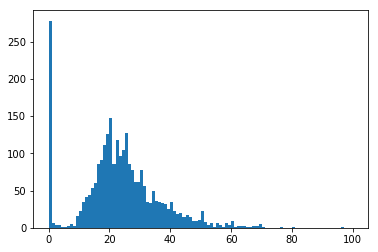

In [495]:
plt.hist(coal.fuel_cost_per_mwh,bins=100,range=(0,100))
plt.show()

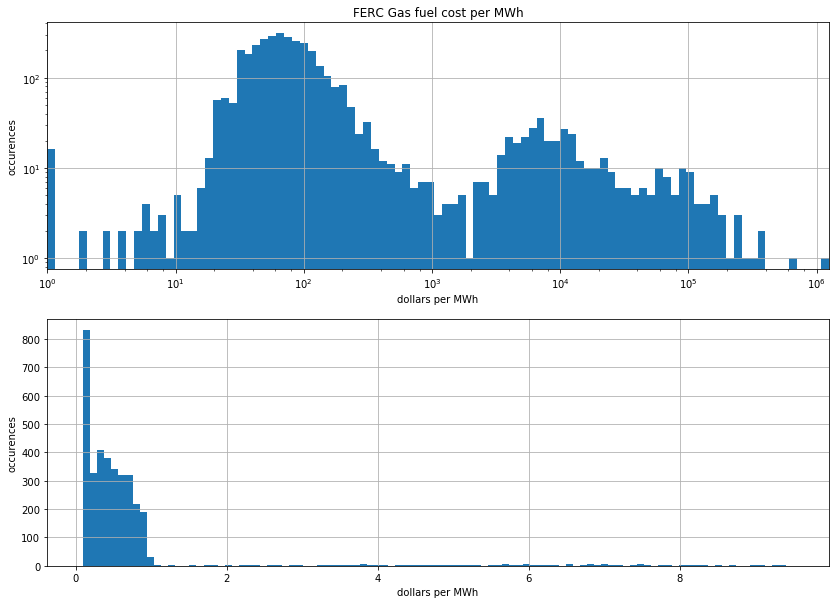

(<matplotlib.figure.Figure at 0x19d7cee48>, 22.862652667666595)

In [507]:
to_fix_gas_cost_per_mwh = gas.fuel_cost_per_mwh
fixed_gas_per_mwh = fixit(gas.fuel_cost_per_mwh,.095,37.8,[1,.001,.01])

showfix(to_fix_gas_cost_per_mwh,fixed_gas_per_mwh,'FERC Gas fuel cost per MWh','dollars per MWh','occurences')

In [508]:
fixed_gas_per_mwh.median()

0.44